In [1]:
# in this notebook, I will focus on setting up experiments and creating figures for my AGU 2021 poster presentation
# this will include:
# design of at least one new experiment (spatially variable precip)
# running out longer timesteps 
# (couldn't do this before due to numerical instability but should be working now with adaptive timestep)
# creation of a new figure showing topographic profile evolution through time

# update 11/30/21:
# By running out loong timesteps, I found that a real period of interest/rapid evolution occurs
# between 100 and 1000 steps
# so now I will change the `num_steps` argument to examine that interval more closely
# in particular, we are interested in the topographic evolution plots for the two tilting scenarios

In [2]:
# star by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# set up runoff rate
r = np.zeros(len(x))
r[:] = 1
double_r = np.zeros(len(x))
double_r[:] = 2
spatially_variable_r = np.zeros(len(x))
spatially_variable_r[:25] = 1
spatially_variable_r[25:] = 2
locally_high_r = np.zeros(len(x))
locally_high_r[:] = 1
locally_high_r[20:36] = 2

# set up references to topography
Hstar = 1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.000064
atr_factor = 0.000004

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 1000000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, cum_time)

In [5]:
# now, want to conduct several experiments
# c, baselevel rate, and porosity will stay same for all; numsteps will change
# here's the order:

# EXP 1
# run to steady state
# ramp tilt, and run back to steady state, capturing state at several timesteps

# EXP 2
# run to steady state
# gaussian tilt, and run back to steady state, capturing state at several timesteps

# EXP 3
# run to steady state
# double discharge everywhere, and run back to steady state, capturing state at several timesteps

# EXP 4
# run to steady state
# double discharge over plains, and run back to steady state, capturing state at several timesteps

# EXP 5
# run to steady state
# locally increase discharge over "foothills"

In [6]:
# EXP 1

exp_1a = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

In [7]:
# run exp 1

(slope_exp_1a,
 sed_flux_exp_1a,
 e_factor_exp_1a,
 topography_exp_1a,
 bedrock_elevation_exp_1a,
 igneous_plucking_rate_exp_1a,
 sedimentary_plucking_rate_exp_1a,
 igneous_abrasion_rate_exp_1a,
 sedimentary_abrasion_rate_exp_1a,
 bedrock_erosion_rate_exp_1a,
 attrition_rate_exp_1a,
 sedimentation_rate_exp_1a,
 sediment_thickness_exp_1a,
 total_erosion_rate_exp_1a,
 cum_time_exp_1a) = two_lith_one_sed(*exp_1a)

2020204.0403882384


In [8]:
# fantastic, our system took about 2 million years to reach steady state
# now provide a tectonic "kick" to the system in the form of a tilt
upstream_tilt_factor = np.linspace(270, 1, 100)

eta_tilt_exp_1b = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1b = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1b = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1c = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1c = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1c = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1d = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1d = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1d = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1e = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1e = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1e = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1f = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1f = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1f = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1g = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1g = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1g = sediment_thickness_exp_1a.copy()

eta_tilt_exp_1h = topography_exp_1a + upstream_tilt_factor
etab_tilt_exp_1h = bedrock_elevation_exp_1a + upstream_tilt_factor
H_exp_1h = sediment_thickness_exp_1a.copy()

In [9]:
# now use the tilted bedrock and topography as inputs to the system
# we expect it to take ~2 million years to reach steady state, so some good snapshots to look at are:
# 1 timestep (exp_1b)
# 10 timesteps (exp_1c)
# 100 timesteps (exp_1d)
# 1000 timesteps (exp_1e)
# 10,000 timesteps (exp_1f)
# 100,000 timesteps (exp_1g)
# 1,000,000 timesteps (exp_1h)

In [10]:
exp_1b = [x, dx, Hstar, H_exp_1b, etab_tilt_exp_1b, eta_tilt_exp_1b, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 100]

exp_1c = [x, dx, Hstar, H_exp_1c, etab_tilt_exp_1c, eta_tilt_exp_1c, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 200]

exp_1d = [x, dx, Hstar, H_exp_1d, etab_tilt_exp_1d, eta_tilt_exp_1d, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 300]

exp_1e = [x, dx, Hstar, H_exp_1e, etab_tilt_exp_1e, eta_tilt_exp_1e, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 400]

exp_1f = [x, dx, Hstar, H_exp_1f, etab_tilt_exp_1f, eta_tilt_exp_1f, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 600]

exp_1g = [x, dx, Hstar, H_exp_1g, etab_tilt_exp_1g, eta_tilt_exp_1g, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 800]

exp_1h = [x, dx, Hstar, H_exp_1h, etab_tilt_exp_1h, eta_tilt_exp_1h, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 1000]

In [11]:
# run the rest of exp_1

(slope_exp_1b,
 sed_flux_exp_1b,
 e_factor_exp_1b,
 topography_exp_1b,
 bedrock_elevation_exp_1b,
 igneous_plucking_rate_exp_1b,
 sedimentary_plucking_rate_exp_1b,
 igneous_abrasion_rate_exp_1b,
 sedimentary_abrasion_rate_exp_1b,
 bedrock_erosion_rate_exp_1b,
 attrition_rate_exp_1b,
 sedimentation_rate_exp_1b,
 sediment_thickness_exp_1b,
 total_erosion_rate_exp_1b,
 cum_time_exp_1b) = two_lith_one_sed(*exp_1b)

(slope_exp_1c,
 sed_flux_exp_1c,
 e_factor_exp_1c,
 topography_exp_1c,
 bedrock_elevation_exp_1c,
 igneous_plucking_rate_exp_1c,
 sedimentary_plucking_rate_exp_1c,
 igneous_abrasion_rate_exp_1c,
 sedimentary_abrasion_rate_exp_1c,
 bedrock_erosion_rate_exp_1c,
 attrition_rate_exp_1c,
 sedimentation_rate_exp_1c,
 sediment_thickness_exp_1c,
 total_erosion_rate_exp_1c,
 cum_time_exp_1c) = two_lith_one_sed(*exp_1c)

(slope_exp_1d,
 sed_flux_exp_1d,
 e_factor_exp_1d,
 topography_exp_1d,
 bedrock_elevation_exp_1d,
 igneous_plucking_rate_exp_1d,
 sedimentary_plucking_rate_exp_1d,
 igneous_abrasion_rate_exp_1d,
 sedimentary_abrasion_rate_exp_1d,
 bedrock_erosion_rate_exp_1d,
 attrition_rate_exp_1d,
 sedimentation_rate_exp_1d,
 sediment_thickness_exp_1d,
 total_erosion_rate_exp_1d,
 cum_time_exp_1d) = two_lith_one_sed(*exp_1d)

(slope_exp_1e,
 sed_flux_exp_1e,
 e_factor_exp_1e,
 topography_exp_1e,
 bedrock_elevation_exp_1e,
 igneous_plucking_rate_exp_1e,
 sedimentary_plucking_rate_exp_1e,
 igneous_abrasion_rate_exp_1e,
 sedimentary_abrasion_rate_exp_1e,
 bedrock_erosion_rate_exp_1e,
 attrition_rate_exp_1e,
 sedimentation_rate_exp_1e,
 sediment_thickness_exp_1e,
 total_erosion_rate_exp_1e,
 cum_time_exp_1e) = two_lith_one_sed(*exp_1e)

(slope_exp_1f,
 sed_flux_exp_1f,
 e_factor_exp_1f,
 topography_exp_1f,
 bedrock_elevation_exp_1f,
 igneous_plucking_rate_exp_1f,
 sedimentary_plucking_rate_exp_1f,
 igneous_abrasion_rate_exp_1f,
 sedimentary_abrasion_rate_exp_1f,
 bedrock_erosion_rate_exp_1f,
 attrition_rate_exp_1f,
 sedimentation_rate_exp_1f,
 sediment_thickness_exp_1f,
 total_erosion_rate_exp_1f,
 cum_time_exp_1f) = two_lith_one_sed(*exp_1f)

(slope_exp_1g,
 sed_flux_exp_1g,
 e_factor_exp_1g,
 topography_exp_1g,
 bedrock_elevation_exp_1g,
 igneous_plucking_rate_exp_1g,
 sedimentary_plucking_rate_exp_1g,
 igneous_abrasion_rate_exp_1g,
 sedimentary_abrasion_rate_exp_1g,
 bedrock_erosion_rate_exp_1g,
 attrition_rate_exp_1g,
 sedimentation_rate_exp_1g,
 sediment_thickness_exp_1g,
 total_erosion_rate_exp_1g,
 cum_time_exp_1g) = two_lith_one_sed(*exp_1g)

(slope_exp_1h,
 sed_flux_exp_1h,
 e_factor_exp_1h,
 topography_exp_1h,
 bedrock_elevation_exp_1h,
 igneous_plucking_rate_exp_1h,
 sedimentary_plucking_rate_exp_1h,
 igneous_abrasion_rate_exp_1h,
 sedimentary_abrasion_rate_exp_1h,
 bedrock_erosion_rate_exp_1h,
 attrition_rate_exp_1h,
 sedimentation_rate_exp_1h,
 sediment_thickness_exp_1h,
 total_erosion_rate_exp_1h,
 cum_time_exp_1h) = two_lith_one_sed(*exp_1h)

202.02020202020205
404.0404040404041
608.0808080808055
810.1010101010019
1214.1414141414054
1616.161616161619
2020.2020202020344


In [12]:
# figures to make:

# (for all, will be 
# 4 stacked panels, one for each experiment, 
# and up to 8 lines per panel (if include all exps. b-h, plus steady condition))

# bedrock erosion rate
# sedimentation rate
# total erosion rate
# sediment thickness?
# grain attrition?
# topographic evolution: digging a hole, and what this looks like for all four scenarios
# illustration of tilting scenarios 
# (scale to make more sensible? 
# put black steady state line on "applied uplift" plot, scaling to make outlet elevation the same)
# for "future work," maybe something related to nondimensionalization exercise?

In [13]:
# alright, now run the next batch of experiments (2b - 2b): applying gaussian tilt
# for starters, just run to steady state using default parameters again

# EXP 2 inputs
exp_2a = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

# run exp 2

(slope_exp_2a,
 sed_flux_exp_2a,
 e_factor_exp_2a,
 topography_exp_2a,
 bedrock_elevation_exp_2a,
 igneous_plucking_rate_exp_2a,
 sedimentary_plucking_rate_exp_2a,
 igneous_abrasion_rate_exp_2a,
 sedimentary_abrasion_rate_exp_2a,
 bedrock_erosion_rate_exp_2a,
 attrition_rate_exp_2a,
 sedimentation_rate_exp_2a,
 sediment_thickness_exp_2a,
 total_erosion_rate_exp_2a,
 cum_time_exp_2a) = two_lith_one_sed(*exp_2a)

2020204.0403882384


In [14]:
# alright, now run the next batch of experiments (2b - 2b): applying gaussian tilt
# to do this, we need to write a function that describes a gaussina curve

# first import necessary libraries
import scipy.stats as stats
import math

# then draw the rest of the fucking bird
mu = x[0]
variance = 0.2
sigma = math.sqrt(variance)
y = np.linspace(mu + 2*sigma, mu + 0*sigma, 100)
curve = 200*stats.norm.pdf(y, mu, sigma)
reversed_curve = curve[::-1]

# great, now add this to the landscape inputs for each subsequent run of this experiment. 
# Adds ~180 m at western edge
eta_gaussian_exp_2b = topography_exp_2a + reversed_curve
etab_gaussian_exp_2b = bedrock_elevation_exp_2a + reversed_curve
H_exp_2b = sediment_thickness_exp_2a.copy()

eta_gaussian_exp_2c = topography_exp_2a + reversed_curve
etab_gaussian_exp_2c = bedrock_elevation_exp_2a + reversed_curve
H_exp_2c = sediment_thickness_exp_2a.copy()

eta_gaussian_exp_2d = topography_exp_2a + reversed_curve
etab_gaussian_exp_2d = bedrock_elevation_exp_2a + reversed_curve
H_exp_2d = sediment_thickness_exp_2a.copy()

eta_gaussian_exp_2e = topography_exp_2a + reversed_curve
etab_gaussian_exp_2e = bedrock_elevation_exp_2a + reversed_curve
H_exp_2e = sediment_thickness_exp_2a.copy()

eta_gaussian_exp_2f = topography_exp_2a + reversed_curve
etab_gaussian_exp_2f = bedrock_elevation_exp_2a + reversed_curve
H_exp_2f = sediment_thickness_exp_2a.copy()

eta_gaussian_exp_2g = topography_exp_2a + reversed_curve
etab_gaussian_exp_2g = bedrock_elevation_exp_2a + reversed_curve
H_exp_2g = sediment_thickness_exp_2a.copy()

eta_gaussian_exp_2h = topography_exp_2a + reversed_curve
etab_gaussian_exp_2h = bedrock_elevation_exp_2a + reversed_curve
H_exp_2h = sediment_thickness_exp_2a.copy()

In [15]:
# great, now add all of these as inputs to experiments

exp_2b = [x, dx, Hstar, H_exp_2b, etab_gaussian_exp_2b, eta_gaussian_exp_2b, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 100]

exp_2c = [x, dx, Hstar, H_exp_2c, etab_gaussian_exp_2c, eta_gaussian_exp_2c, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 200]

exp_2d = [x, dx, Hstar, H_exp_2d, etab_gaussian_exp_2d, eta_gaussian_exp_2d, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 300]

exp_2e = [x, dx, Hstar, H_exp_2e, etab_gaussian_exp_2e, eta_gaussian_exp_2e, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 400]

exp_2f = [x, dx, Hstar, H_exp_2f, etab_gaussian_exp_2f, eta_gaussian_exp_2f, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 600]

exp_2g = [x, dx, Hstar, H_exp_2g, etab_gaussian_exp_2g, eta_gaussian_exp_2g, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 800]

exp_2h = [x, dx, Hstar, H_exp_2h, etab_gaussian_exp_2h, eta_gaussian_exp_2h, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 1000]

In [16]:
# wahooooo, now run the rest of exp_2

(slope_exp_2b,
 sed_flux_exp_2b,
 e_factor_exp_2b,
 topography_exp_2b,
 bedrock_elevation_exp_2b,
 igneous_plucking_rate_exp_2b,
 sedimentary_plucking_rate_exp_2b,
 igneous_abrasion_rate_exp_2b,
 sedimentary_abrasion_rate_exp_2b,
 bedrock_erosion_rate_exp_2b,
 attrition_rate_exp_2b,
 sedimentation_rate_exp_2b,
 sediment_thickness_exp_2b,
 total_erosion_rate_exp_2b,
 cum_time_exp_2b) = two_lith_one_sed(*exp_2b)

(slope_exp_2c,
 sed_flux_exp_2c,
 e_factor_exp_2c,
 topography_exp_2c,
 bedrock_elevation_exp_2c,
 igneous_plucking_rate_exp_2c,
 sedimentary_plucking_rate_exp_2c,
 igneous_abrasion_rate_exp_2c,
 sedimentary_abrasion_rate_exp_2c,
 bedrock_erosion_rate_exp_2c,
 attrition_rate_exp_2c,
 sedimentation_rate_exp_2c,
 sediment_thickness_exp_2c,
 total_erosion_rate_exp_2c,
 cum_time_exp_2c) = two_lith_one_sed(*exp_2c)

(slope_exp_2d,
 sed_flux_exp_2d,
 e_factor_exp_2d,
 topography_exp_2d,
 bedrock_elevation_exp_2d,
 igneous_plucking_rate_exp_2d,
 sedimentary_plucking_rate_exp_2d,
 igneous_abrasion_rate_exp_2d,
 sedimentary_abrasion_rate_exp_2d,
 bedrock_erosion_rate_exp_2d,
 attrition_rate_exp_2d,
 sedimentation_rate_exp_2d,
 sediment_thickness_exp_2d,
 total_erosion_rate_exp_2d,
 cum_time_exp_2d) = two_lith_one_sed(*exp_2d)

(slope_exp_2e,
 sed_flux_exp_2e,
 e_factor_exp_2e,
 topography_exp_2e,
 bedrock_elevation_exp_2e,
 igneous_plucking_rate_exp_2e,
 sedimentary_plucking_rate_exp_2e,
 igneous_abrasion_rate_exp_2e,
 sedimentary_abrasion_rate_exp_2e,
 bedrock_erosion_rate_exp_2e,
 attrition_rate_exp_2e,
 sedimentation_rate_exp_2e,
 sediment_thickness_exp_2e,
 total_erosion_rate_exp_2e,
 cum_time_exp_2e) = two_lith_one_sed(*exp_2e)

(slope_exp_2f,
 sed_flux_exp_2f,
 e_factor_exp_2f,
 topography_exp_2f,
 bedrock_elevation_exp_2f,
 igneous_plucking_rate_exp_2f,
 sedimentary_plucking_rate_exp_2f,
 igneous_abrasion_rate_exp_2f,
 sedimentary_abrasion_rate_exp_2f,
 bedrock_erosion_rate_exp_2f,
 attrition_rate_exp_2f,
 sedimentation_rate_exp_2f,
 sediment_thickness_exp_2f,
 total_erosion_rate_exp_2f,
 cum_time_exp_2f) = two_lith_one_sed(*exp_2f)

(slope_exp_2g,
 sed_flux_exp_2g,
 e_factor_exp_2g,
 topography_exp_2g,
 bedrock_elevation_exp_2g,
 igneous_plucking_rate_exp_2g,
 sedimentary_plucking_rate_exp_2g,
 igneous_abrasion_rate_exp_2g,
 sedimentary_abrasion_rate_exp_2g,
 bedrock_erosion_rate_exp_2g,
 attrition_rate_exp_2g,
 sedimentation_rate_exp_2g,
 sediment_thickness_exp_2g,
 total_erosion_rate_exp_2g,
 cum_time_exp_2g) = two_lith_one_sed(*exp_2g)

(slope_exp_2h,
 sed_flux_exp_2h,
 e_factor_exp_2h,
 topography_exp_2h,
 bedrock_elevation_exp_2h,
 igneous_plucking_rate_exp_2h,
 sedimentary_plucking_rate_exp_2h,
 igneous_abrasion_rate_exp_2h,
 sedimentary_abrasion_rate_exp_2h,
 bedrock_erosion_rate_exp_2h,
 attrition_rate_exp_2h,
 sedimentation_rate_exp_2h,
 sediment_thickness_exp_2h,
 total_erosion_rate_exp_2h,
 cum_time_exp_2h) = two_lith_one_sed(*exp_2h)

202.02020202020205
404.0404040404041
608.0808080808055
810.1010101010019
1214.1414141414054
1616.161616161619
2020.2020202020344


In [17]:
# alright, time for the next batch of experiments (3b - 3b): doubling discharge everywhere
# for starters, just run to steady state using default parameters again

Hstar_small = 0.1

# EXP 3 inputs
exp_3a = [x, dx, Hstar_small, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, 1, 0.001, 850000]

In [18]:
# run exp_3a in order to name/grab outputs

(slope_exp_3a,
 sed_flux_exp_3a,
 e_factor_exp_3a,
 topography_exp_3a,
 bedrock_elevation_exp_3a,
 igneous_plucking_rate_exp_3a,
 sedimentary_plucking_rate_exp_3a,
 igneous_abrasion_rate_exp_3a,
 sedimentary_abrasion_rate_exp_3a,
 bedrock_erosion_rate_exp_3a,
 attrition_rate_exp_3a,
 sedimentation_rate_exp_3a,
 sediment_thickness_exp_3a,
 total_erosion_rate_exp_3a,
 cum_time_exp_3a) = two_lith_one_sed(*exp_3a)

1717173.7373607575


In [19]:
# and now create a bunch of copies of the topo, bedrock, and soil 
# created by this first run to feed into the subsequent runs

eta_exp_3b = topography_exp_3a.copy()
etab_exp_3b = bedrock_elevation_exp_3a.copy()
H_exp_3b = sediment_thickness_exp_3a.copy()

eta_exp_3c = topography_exp_3a.copy()
etab_exp_3c = bedrock_elevation_exp_3a.copy()
H_exp_3c = sediment_thickness_exp_3a.copy()

eta_exp_3d = topography_exp_3a.copy()
etab_exp_3d = bedrock_elevation_exp_3a.copy()
H_exp_3d = sediment_thickness_exp_3a.copy()

eta_exp_3e = topography_exp_3a.copy()
etab_exp_3e = bedrock_elevation_exp_3a.copy()
H_exp_3e = sediment_thickness_exp_3a.copy()

eta_exp_3f = topography_exp_3a.copy()
etab_exp_3f = bedrock_elevation_exp_3a.copy()
H_exp_3f = sediment_thickness_exp_3a.copy()

eta_exp_3g = topography_exp_3a.copy()
etab_exp_3g = bedrock_elevation_exp_3a.copy()
H_exp_3g = sediment_thickness_exp_3a.copy()

eta_exp_3h = topography_exp_3a.copy()
etab_exp_3h = bedrock_elevation_exp_3a.copy()
H_exp_3h = sediment_thickness_exp_3a.copy()

In [20]:
# neato. Now set up inputs for subsequent sub-experiments.

# EXP 3 inputs
exp_3b = [x, dx, Hstar, H_exp_3b, etab_exp_3b, eta_exp_3b, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 100]

exp_3c = [x, dx, Hstar, H_exp_3c, etab_exp_3c, eta_exp_3c, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 200]

exp_3d = [x, dx, Hstar, H_exp_3d, etab_exp_3d, eta_exp_3d, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 300]

exp_3e = [x, dx, Hstar, H_exp_3e, etab_exp_3e, eta_exp_3e, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 400]

exp_3f = [x, dx, Hstar, H_exp_3f, etab_exp_3f, eta_exp_3f, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 600]

exp_3g = [x, dx, Hstar, H_exp_3g, etab_exp_3g, eta_exp_3g, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 800]

exp_3h = [x, dx, Hstar, H_exp_3h, etab_exp_3h, eta_exp_3h, beta_ig, beta_sed, atr_factor, k_ig, k_sed, double_r, 1, 0.001, 1000]

In [21]:
# and feed these into our function runs for the rest of exp_3

(slope_exp_3b,
 sed_flux_exp_3b,
 e_factor_exp_3b,
 topography_exp_3b,
 bedrock_elevation_exp_3b,
 igneous_plucking_rate_exp_3b,
 sedimentary_plucking_rate_exp_3b,
 igneous_abrasion_rate_exp_3b,
 sedimentary_abrasion_rate_exp_3b,
 bedrock_erosion_rate_exp_3b,
 attrition_rate_exp_3b,
 sedimentation_rate_exp_3b,
 sediment_thickness_exp_3b,
 total_erosion_rate_exp_3b,
 cum_time_exp_3b) = two_lith_one_sed(*exp_3b)

(slope_exp_3c,
 sed_flux_exp_3c,
 e_factor_exp_3c,
 topography_exp_3c,
 bedrock_elevation_exp_3c,
 igneous_plucking_rate_exp_3c,
 sedimentary_plucking_rate_exp_3c,
 igneous_abrasion_rate_exp_3c,
 sedimentary_abrasion_rate_exp_3c,
 bedrock_erosion_rate_exp_3c,
 attrition_rate_exp_3c,
 sedimentation_rate_exp_3c,
 sediment_thickness_exp_3c,
 total_erosion_rate_exp_3c,
 cum_time_exp_3c) = two_lith_one_sed(*exp_3c)

(slope_exp_3d,
 sed_flux_exp_3d,
 e_factor_exp_3d,
 topography_exp_3d,
 bedrock_elevation_exp_3d,
 igneous_plucking_rate_exp_3d,
 sedimentary_plucking_rate_exp_3d,
 igneous_abrasion_rate_exp_3d,
 sedimentary_abrasion_rate_exp_3d,
 bedrock_erosion_rate_exp_3d,
 attrition_rate_exp_3d,
 sedimentation_rate_exp_3d,
 sediment_thickness_exp_3d,
 total_erosion_rate_exp_3d,
 cum_time_exp_3d) = two_lith_one_sed(*exp_3d)

(slope_exp_3e,
 sed_flux_exp_3e,
 e_factor_exp_3e,
 topography_exp_3e,
 bedrock_elevation_exp_3e,
 igneous_plucking_rate_exp_3e,
 sedimentary_plucking_rate_exp_3e,
 igneous_abrasion_rate_exp_3e,
 sedimentary_abrasion_rate_exp_3e,
 bedrock_erosion_rate_exp_3e,
 attrition_rate_exp_3e,
 sedimentation_rate_exp_3e,
 sediment_thickness_exp_3e,
 total_erosion_rate_exp_3e,
 cum_time_exp_3e) = two_lith_one_sed(*exp_3e)

(slope_exp_3f,
 sed_flux_exp_3f,
 e_factor_exp_3f,
 topography_exp_3f,
 bedrock_elevation_exp_3f,
 igneous_plucking_rate_exp_3f,
 sedimentary_plucking_rate_exp_3f,
 igneous_abrasion_rate_exp_3f,
 sedimentary_abrasion_rate_exp_3f,
 bedrock_erosion_rate_exp_3f,
 attrition_rate_exp_3f,
 sedimentation_rate_exp_3f,
 sediment_thickness_exp_3f,
 total_erosion_rate_exp_3f,
 cum_time_exp_3f) = two_lith_one_sed(*exp_3f)

(slope_exp_3g,
 sed_flux_exp_3g,
 e_factor_exp_3g,
 topography_exp_3g,
 bedrock_elevation_exp_3g,
 igneous_plucking_rate_exp_3g,
 sedimentary_plucking_rate_exp_3g,
 igneous_abrasion_rate_exp_3g,
 sedimentary_abrasion_rate_exp_3g,
 bedrock_erosion_rate_exp_3g,
 attrition_rate_exp_3g,
 sedimentation_rate_exp_3g,
 sediment_thickness_exp_3g,
 total_erosion_rate_exp_3g,
 cum_time_exp_3g) = two_lith_one_sed(*exp_3g)

(slope_exp_3h,
 sed_flux_exp_3h,
 e_factor_exp_3h,
 topography_exp_3h,
 bedrock_elevation_exp_3h,
 igneous_plucking_rate_exp_3h,
 sedimentary_plucking_rate_exp_3h,
 igneous_abrasion_rate_exp_3h,
 sedimentary_abrasion_rate_exp_3h,
 bedrock_erosion_rate_exp_3h,
 attrition_rate_exp_3h,
 sedimentation_rate_exp_3h,
 sediment_thickness_exp_3h,
 total_erosion_rate_exp_3h,
 cum_time_exp_3h) = two_lith_one_sed(*exp_3h)

101.01010101010102
202.02020202020205
304.04040404040273
405.05050505050093
607.0707070707027
808.0808080808094
1010.1010101010172


In [22]:
# yaaaaaaaas queeeeeeeeen now just do the exact same for the next batch of experiments (4b - 4b)
# except replace `double_r` with `spatially_variable_r`

# for starters, run to steady state using default parameters again

# EXP 4 inputs
exp_4a = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

In [23]:
# run the starting case (4a) to steady state
(slope_exp_4a,
 sed_flux_exp_4a,
 e_factor_exp_4a,
 topography_exp_4a,
 bedrock_elevation_exp_4a,
 igneous_plucking_rate_exp_4a,
 sedimentary_plucking_rate_exp_4a,
 igneous_abrasion_rate_exp_4a,
 sedimentary_abrasion_rate_exp_4a,
 bedrock_erosion_rate_exp_4a,
 attrition_rate_exp_4a,
 sedimentation_rate_exp_4a,
 sediment_thickness_exp_4a,
 total_erosion_rate_exp_4a,
 cum_time_exp_4a) = two_lith_one_sed(*exp_4a)

2020204.0403882384


In [24]:
# grab outputs, make copies of topographic elements to feed as inputs into subsequent runs

eta_exp_4b = topography_exp_4a.copy()
etab_exp_4b = bedrock_elevation_exp_4a.copy()
H_exp_4b = sediment_thickness_exp_4a.copy()

eta_exp_4c = topography_exp_4a.copy()
etab_exp_4c = bedrock_elevation_exp_4a.copy()
H_exp_4c = sediment_thickness_exp_4a.copy()

eta_exp_4d = topography_exp_4a.copy()
etab_exp_4d = bedrock_elevation_exp_4a.copy()
H_exp_4d = sediment_thickness_exp_4a.copy()

eta_exp_4e = topography_exp_4a.copy()
etab_exp_4e = bedrock_elevation_exp_4a.copy()
H_exp_4e = sediment_thickness_exp_4a.copy()

eta_exp_4f = topography_exp_4a.copy()
etab_exp_4f = bedrock_elevation_exp_4a.copy()
H_exp_4f = sediment_thickness_exp_4a.copy()

eta_exp_4g = topography_exp_4a.copy()
etab_exp_4g = bedrock_elevation_exp_4a.copy()
H_exp_4g = sediment_thickness_exp_4a.copy()

eta_exp_4h = topography_exp_4a.copy()
etab_exp_4h = bedrock_elevation_exp_4a.copy()
H_exp_4h = sediment_thickness_exp_4a.copy()

In [25]:
# and set up some inputs

# EXP 4 inputs
exp_4b = [x, dx, Hstar, H_exp_4b, etab_exp_4b, eta_exp_4b, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 100]

# EXP 4 inputs
exp_4c = [x, dx, Hstar, H_exp_4c, etab_exp_4c, eta_exp_4c, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 200]

# EXP 4 inputs
exp_4d = [x, dx, Hstar, H_exp_4d, etab_exp_4d, eta_exp_4d, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 300]

# EXP 4 inputs
exp_4e = [x, dx, Hstar, H_exp_4e, etab_exp_4e, eta_exp_4e, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 400]

# EXP 3 inputs
exp_4f = [x, dx, Hstar, H_exp_4f, etab_exp_4f, eta_exp_4f, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 600]

# EXP 3 inputs
exp_4g = [x, dx, Hstar, H_exp_4g, etab_exp_4g, eta_exp_4g, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 800]

# EXP 3 inputs
exp_4h = [x, dx, Hstar, H_exp_4h, etab_exp_4h, eta_exp_4h, beta_ig, beta_sed, atr_factor, k_ig, k_sed, spatially_variable_r, 1, 0.001, 1000]

In [26]:
# and finally, check out a bunch of snapshots with what happens whenwe make precip spatially variable!

(slope_exp_4b,
 sed_flux_exp_4b,
 e_factor_exp_4b,
 topography_exp_4b,
 bedrock_elevation_exp_4b,
 igneous_plucking_rate_exp_4b,
 sedimentary_plucking_rate_exp_4b,
 igneous_abrasion_rate_exp_4b,
 sedimentary_abrasion_rate_exp_4b,
 bedrock_erosion_rate_exp_4b,
 attrition_rate_exp_4b,
 sedimentation_rate_exp_4b,
 sediment_thickness_exp_4b,
 total_erosion_rate_exp_4b,
 cum_time_exp_4b) = two_lith_one_sed(*exp_4b)

(slope_exp_4c,
 sed_flux_exp_4c,
 e_factor_exp_4c,
 topography_exp_4c,
 bedrock_elevation_exp_4c,
 igneous_plucking_rate_exp_4c,
 sedimentary_plucking_rate_exp_4c,
 igneous_abrasion_rate_exp_4c,
 sedimentary_abrasion_rate_exp_4c,
 bedrock_erosion_rate_exp_4c,
 attrition_rate_exp_4c,
 sedimentation_rate_exp_4c,
 sediment_thickness_exp_4c,
 total_erosion_rate_exp_4c,
 cum_time_exp_4c) = two_lith_one_sed(*exp_4c)

(slope_exp_4d,
 sed_flux_exp_4d,
 e_factor_exp_4d,
 topography_exp_4d,
 bedrock_elevation_exp_4d,
 igneous_plucking_rate_exp_4d,
 sedimentary_plucking_rate_exp_4d,
 igneous_abrasion_rate_exp_4d,
 sedimentary_abrasion_rate_exp_4d,
 bedrock_erosion_rate_exp_4d,
 attrition_rate_exp_4d,
 sedimentation_rate_exp_4d,
 sediment_thickness_exp_4d,
 total_erosion_rate_exp_4d,
 cum_time_exp_4d) = two_lith_one_sed(*exp_4d)

(slope_exp_4e,
 sed_flux_exp_4e,
 e_factor_exp_4e,
 topography_exp_4e,
 bedrock_elevation_exp_4e,
 igneous_plucking_rate_exp_4e,
 sedimentary_plucking_rate_exp_4e,
 igneous_abrasion_rate_exp_4e,
 sedimentary_abrasion_rate_exp_4e,
 bedrock_erosion_rate_exp_4e,
 attrition_rate_exp_4e,
 sedimentation_rate_exp_4e,
 sediment_thickness_exp_4e,
 total_erosion_rate_exp_4e,
 cum_time_exp_4e) = two_lith_one_sed(*exp_4e)

(slope_exp_4f,
 sed_flux_exp_4f,
 e_factor_exp_4f,
 topography_exp_4f,
 bedrock_elevation_exp_4f,
 igneous_plucking_rate_exp_4f,
 sedimentary_plucking_rate_exp_4f,
 igneous_abrasion_rate_exp_4f,
 sedimentary_abrasion_rate_exp_4f,
 bedrock_erosion_rate_exp_4f,
 attrition_rate_exp_4f,
 sedimentation_rate_exp_4f,
 sediment_thickness_exp_4f,
 total_erosion_rate_exp_4f,
 cum_time_exp_4f) = two_lith_one_sed(*exp_4f)

(slope_exp_4g,
 sed_flux_exp_4g,
 e_factor_exp_4g,
 topography_exp_4g,
 bedrock_elevation_exp_4g,
 igneous_plucking_rate_exp_4g,
 sedimentary_plucking_rate_exp_4g,
 igneous_abrasion_rate_exp_4g,
 sedimentary_abrasion_rate_exp_4g,
 bedrock_erosion_rate_exp_4g,
 attrition_rate_exp_4g,
 sedimentation_rate_exp_4g,
 sediment_thickness_exp_4g,
 total_erosion_rate_exp_4g,
 cum_time_exp_4g) = two_lith_one_sed(*exp_4g)

(slope_exp_4h,
 sed_flux_exp_4h,
 e_factor_exp_4h,
 topography_exp_4h,
 bedrock_elevation_exp_4h,
 igneous_plucking_rate_exp_4h,
 sedimentary_plucking_rate_exp_4h,
 igneous_abrasion_rate_exp_4h,
 sedimentary_abrasion_rate_exp_4h,
 bedrock_erosion_rate_exp_4h,
 attrition_rate_exp_4h,
 sedimentation_rate_exp_4h,
 sediment_thickness_exp_4h,
 total_erosion_rate_exp_4h,
 cum_time_exp_4h) = two_lith_one_sed(*exp_4h)

101.01010101010102
202.02020202020205
304.04040404040273
405.05050505050093
607.0707070707027
808.0808080808094
1010.1010101010172


In [27]:
# for starters, run to steady state using default parameters again

# EXP 5 inputs
exp_5a = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

In [28]:
# run the starting case (5a) to steady state
(slope_exp_5a,
 sed_flux_exp_5a,
 e_factor_exp_5a,
 topography_exp_5a,
 bedrock_elevation_exp_5a,
 igneous_plucking_rate_exp_5a,
 sedimentary_plucking_rate_exp_5a,
 igneous_abrasion_rate_exp_5a,
 sedimentary_abrasion_rate_exp_5a,
 bedrock_erosion_rate_exp_5a,
 attrition_rate_exp_5a,
 sedimentation_rate_exp_5a,
 sediment_thickness_exp_5a,
 total_erosion_rate_exp_5a,
 cum_time_exp_5a) = two_lith_one_sed(*exp_5a)

2020204.0403882384


In [29]:
# grab outputs, make copies of topographic elements to feed as inputs into subsequent runs

eta_exp_5b = topography_exp_5a.copy()
etab_exp_5b = bedrock_elevation_exp_5a.copy()
H_exp_5b = sediment_thickness_exp_5a.copy()

eta_exp_5c = topography_exp_5a.copy()
etab_exp_5c = bedrock_elevation_exp_5a.copy()
H_exp_5c = sediment_thickness_exp_5a.copy()

eta_exp_5d = topography_exp_5a.copy()
etab_exp_5d = bedrock_elevation_exp_5a.copy()
H_exp_5d = sediment_thickness_exp_5a.copy()

eta_exp_5e = topography_exp_5a.copy()
etab_exp_5e = bedrock_elevation_exp_5a.copy()
H_exp_5e = sediment_thickness_exp_5a.copy()

eta_exp_5f = topography_exp_5a.copy()
etab_exp_5f = bedrock_elevation_exp_5a.copy()
H_exp_5f = sediment_thickness_exp_5a.copy()

eta_exp_5g = topography_exp_5a.copy()
etab_exp_5g = bedrock_elevation_exp_5a.copy()
H_exp_5g = sediment_thickness_exp_5a.copy()

eta_exp_5h = topography_exp_5a.copy()
etab_exp_5h = bedrock_elevation_exp_5a.copy()
H_exp_5h = sediment_thickness_exp_5a.copy()

In [30]:
# EXP 5 inputs
exp_5b = [x, dx, Hstar, H_exp_5b, etab_exp_5b, eta_exp_5b, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 100]

exp_5c = [x, dx, Hstar, H_exp_5c, etab_exp_5c, eta_exp_5c, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 200]

exp_5d = [x, dx, Hstar, H_exp_5d, etab_exp_5d, eta_exp_5d, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 300]

exp_5e = [x, dx, Hstar, H_exp_5e, etab_exp_5e, eta_exp_5e, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 400]

exp_5f = [x, dx, Hstar, H_exp_5f, etab_exp_5f, eta_exp_5f, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 600]

exp_5g = [x, dx, Hstar, H_exp_5g, etab_exp_5g, eta_exp_5g, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 800]

exp_5h = [x, dx, Hstar, H_exp_5h, etab_exp_5h, eta_exp_5h, beta_ig, beta_sed, atr_factor, k_ig, k_sed, locally_high_r, 1, 0.001, 1000]

In [31]:
# and finally, check out a bunch of snapshots with what happens when we make precip spatially variable!

(slope_exp_5b,
 sed_flux_exp_5b,
 e_factor_exp_5b,
 topography_exp_5b,
 bedrock_elevation_exp_5b,
 igneous_plucking_rate_exp_5b,
 sedimentary_plucking_rate_exp_5b,
 igneous_abrasion_rate_exp_5b,
 sedimentary_abrasion_rate_exp_5b,
 bedrock_erosion_rate_exp_5b,
 attrition_rate_exp_5b,
 sedimentation_rate_exp_5b,
 sediment_thickness_exp_5b,
 total_erosion_rate_exp_5b,
 cum_time_exp_5b) = two_lith_one_sed(*exp_5b)

(slope_exp_5c,
 sed_flux_exp_5c,
 e_factor_exp_5c,
 topography_exp_5c,
 bedrock_elevation_exp_5c,
 igneous_plucking_rate_exp_5c,
 sedimentary_plucking_rate_exp_5c,
 igneous_abrasion_rate_exp_5c,
 sedimentary_abrasion_rate_exp_5c,
 bedrock_erosion_rate_exp_5c,
 attrition_rate_exp_5c,
 sedimentation_rate_exp_5c,
 sediment_thickness_exp_5c,
 total_erosion_rate_exp_5c,
 cum_time_exp_5c) = two_lith_one_sed(*exp_5c)

(slope_exp_5d,
 sed_flux_exp_5d,
 e_factor_exp_5d,
 topography_exp_5d,
 bedrock_elevation_exp_5d,
 igneous_plucking_rate_exp_5d,
 sedimentary_plucking_rate_exp_5d,
 igneous_abrasion_rate_exp_5d,
 sedimentary_abrasion_rate_exp_5d,
 bedrock_erosion_rate_exp_5d,
 attrition_rate_exp_5d,
 sedimentation_rate_exp_5d,
 sediment_thickness_exp_5d,
 total_erosion_rate_exp_5d,
 cum_time_exp_5d) = two_lith_one_sed(*exp_5d)

(slope_exp_5e,
 sed_flux_exp_5e,
 e_factor_exp_5e,
 topography_exp_5e,
 bedrock_elevation_exp_5e,
 igneous_plucking_rate_exp_5e,
 sedimentary_plucking_rate_exp_5e,
 igneous_abrasion_rate_exp_5e,
 sedimentary_abrasion_rate_exp_5e,
 bedrock_erosion_rate_exp_5e,
 attrition_rate_exp_5e,
 sedimentation_rate_exp_5e,
 sediment_thickness_exp_5e,
 total_erosion_rate_exp_5e,
 cum_time_exp_5e) = two_lith_one_sed(*exp_5e)

(slope_exp_5f,
 sed_flux_exp_5f,
 e_factor_exp_5f,
 topography_exp_5f,
 bedrock_elevation_exp_5f,
 igneous_plucking_rate_exp_5f,
 sedimentary_plucking_rate_exp_5f,
 igneous_abrasion_rate_exp_5f,
 sedimentary_abrasion_rate_exp_5f,
 bedrock_erosion_rate_exp_5f,
 attrition_rate_exp_5f,
 sedimentation_rate_exp_5f,
 sediment_thickness_exp_5f,
 total_erosion_rate_exp_5f,
 cum_time_exp_5f) = two_lith_one_sed(*exp_5f)

(slope_exp_5g,
 sed_flux_exp_5g,
 e_factor_exp_5g,
 topography_exp_5g,
 bedrock_elevation_exp_5g,
 igneous_plucking_rate_exp_5g,
 sedimentary_plucking_rate_exp_5g,
 igneous_abrasion_rate_exp_5g,
 sedimentary_abrasion_rate_exp_5g,
 bedrock_erosion_rate_exp_5g,
 attrition_rate_exp_5g,
 sedimentation_rate_exp_5g,
 sediment_thickness_exp_5g,
 total_erosion_rate_exp_5g,
 cum_time_exp_5g) = two_lith_one_sed(*exp_5g)

(slope_exp_5h,
 sed_flux_exp_5h,
 e_factor_exp_5h,
 topography_exp_5h,
 bedrock_elevation_exp_5h,
 igneous_plucking_rate_exp_5h,
 sedimentary_plucking_rate_exp_5h,
 igneous_abrasion_rate_exp_5h,
 sedimentary_abrasion_rate_exp_5h,
 bedrock_erosion_rate_exp_5h,
 attrition_rate_exp_5h,
 sedimentation_rate_exp_5h,
 sediment_thickness_exp_5h,
 total_erosion_rate_exp_5h,
 cum_time_exp_5h) = two_lith_one_sed(*exp_5h)

202.02020202020205
404.0404040404041
608.0808080808055
810.1010101010019
1214.1414141414054
1616.161616161619
2020.2020202020344


Text(0.5, 1.0, 'Locally increased discharge')

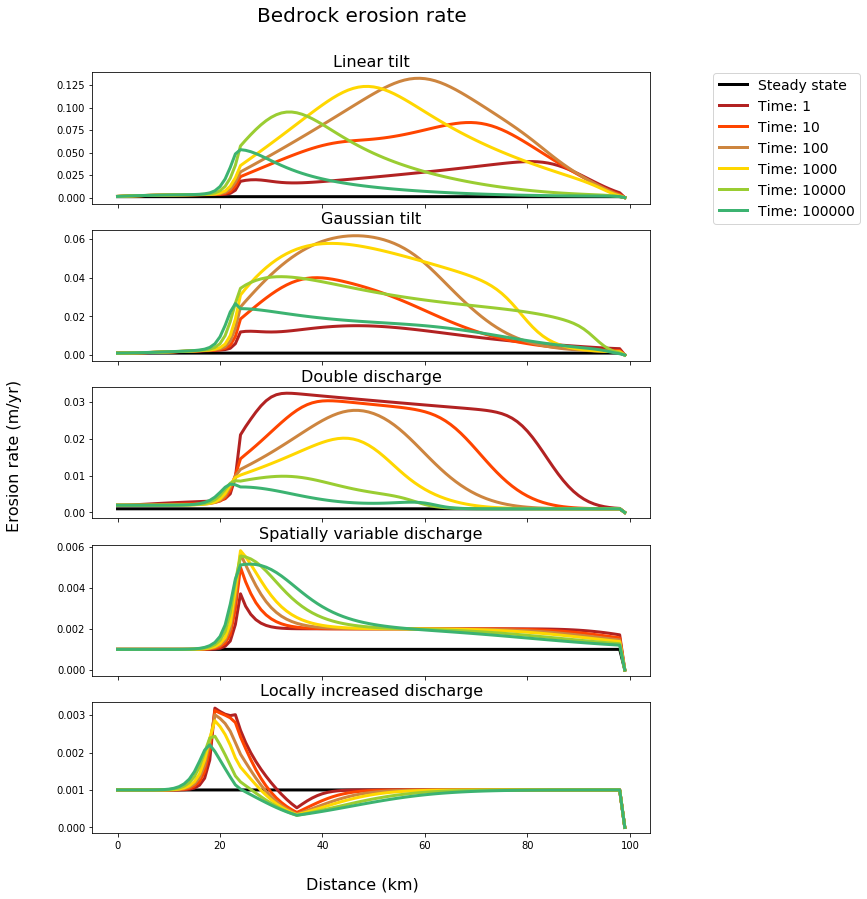

In [32]:
# WA. HOO. We should now have everything we need to make a nice set of figures. 
# Start with subplots showing bedrock erosion rates

fig, axs = plt.subplots(5, sharex = True, figsize = (10, 14))

fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Bedrock erosion rate', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Erosion rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

axs[0].plot(x/1000, bedrock_erosion_rate_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
axs[0].plot(x/1000, bedrock_erosion_rate_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
axs[0].plot(x/1000, bedrock_erosion_rate_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
axs[0].plot(x/1000, bedrock_erosion_rate_exp_1d, label = 'Time: 100', color = 'peru', linewidth = 3)
axs[0].plot(x/1000, bedrock_erosion_rate_exp_1e, label = 'Time: 1000', color = 'gold', linewidth = 3)
axs[0].plot(x/1000, bedrock_erosion_rate_exp_1f, label = 'Time: 10000', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x/1000, bedrock_erosion_rate_exp_1g, label = 'Time: 100000', color = 'mediumseagreen', linewidth = 3)
# axs[0].plot(x/1000, bedrock_erosion_rate_exp_1h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
axs[0].legend(bbox_to_anchor=(1.1, 1.05), fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

axs[1].plot(x/1000, bedrock_erosion_rate_exp_2a, color = 'k', linewidth = 3)
axs[1].plot(x/1000, bedrock_erosion_rate_exp_2b, color = 'firebrick', linewidth = 3)
axs[1].plot(x/1000, bedrock_erosion_rate_exp_2c, color = 'orangered', linewidth = 3)
axs[1].plot(x/1000, bedrock_erosion_rate_exp_2d, color = 'peru', linewidth = 3)
axs[1].plot(x/1000, bedrock_erosion_rate_exp_2e, color = 'gold', linewidth = 3)
axs[1].plot(x/1000, bedrock_erosion_rate_exp_2f, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x/1000, bedrock_erosion_rate_exp_2g, color = 'mediumseagreen', linewidth = 3)
# axs[1].plot(x/1000, bedrock_erosion_rate_exp_2h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[1].legend(fontsize = 14)
axs[1].set_title('Gaussian tilt', fontsize = 16)

axs[2].plot(x/1000, bedrock_erosion_rate_exp_3a, color = 'k', linewidth = 3)
axs[2].plot(x/1000, bedrock_erosion_rate_exp_3b, color = 'firebrick', linewidth = 3)
axs[2].plot(x/1000, bedrock_erosion_rate_exp_3c, color = 'orangered', linewidth = 3)
axs[2].plot(x/1000, bedrock_erosion_rate_exp_3d, color = 'peru', linewidth = 3)
axs[2].plot(x/1000, bedrock_erosion_rate_exp_3e, color = 'gold', linewidth = 3)
axs[2].plot(x/1000, bedrock_erosion_rate_exp_3f, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x/1000, bedrock_erosion_rate_exp_3g, color = 'mediumseagreen', linewidth = 3)
# axs[2].plot(x/1000, bedrock_erosion_rate_exp_3h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[2].legend(fontsize = 14)
axs[2].set_title('Double discharge', fontsize = 16)

axs[3].plot(x/1000, bedrock_erosion_rate_exp_4a, color = 'k', linewidth = 3)
axs[3].plot(x/1000, bedrock_erosion_rate_exp_4b, color = 'firebrick', linewidth = 3)
axs[3].plot(x/1000, bedrock_erosion_rate_exp_4c, color = 'orangered', linewidth = 3)
axs[3].plot(x/1000, bedrock_erosion_rate_exp_4d, color = 'peru', linewidth = 3)
axs[3].plot(x/1000, bedrock_erosion_rate_exp_4e, color = 'gold', linewidth = 3)
axs[3].plot(x/1000, bedrock_erosion_rate_exp_4f, color = 'yellowgreen', linewidth = 3)
axs[3].plot(x/1000, bedrock_erosion_rate_exp_4g, color = 'mediumseagreen', linewidth = 3)
# axs[3].plot(x/1000, bedrock_erosion_rate_exp_4h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[3].set_title('Spatially variable discharge', fontsize = 16)

axs[4].plot(x/1000, bedrock_erosion_rate_exp_5a, color = 'k', linewidth = 3)
axs[4].plot(x/1000, bedrock_erosion_rate_exp_5b, color = 'firebrick', linewidth = 3)
axs[4].plot(x/1000, bedrock_erosion_rate_exp_5c, color = 'orangered', linewidth = 3)
axs[4].plot(x/1000, bedrock_erosion_rate_exp_5d, color = 'peru', linewidth = 3)
axs[4].plot(x/1000, bedrock_erosion_rate_exp_5e, color = 'gold', linewidth = 3)
axs[4].plot(x/1000, bedrock_erosion_rate_exp_5f, color = 'yellowgreen', linewidth = 3)
axs[4].plot(x/1000, bedrock_erosion_rate_exp_5g, color = 'mediumseagreen', linewidth = 3)
# axs[3].plot(x/1000, bedrock_erosion_rate_exp_4h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[4].set_title('Locally increased discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/AGU 2021/bedrock erosion rates.png')

Text(0.5, 1.0, 'Locally increased discharge')

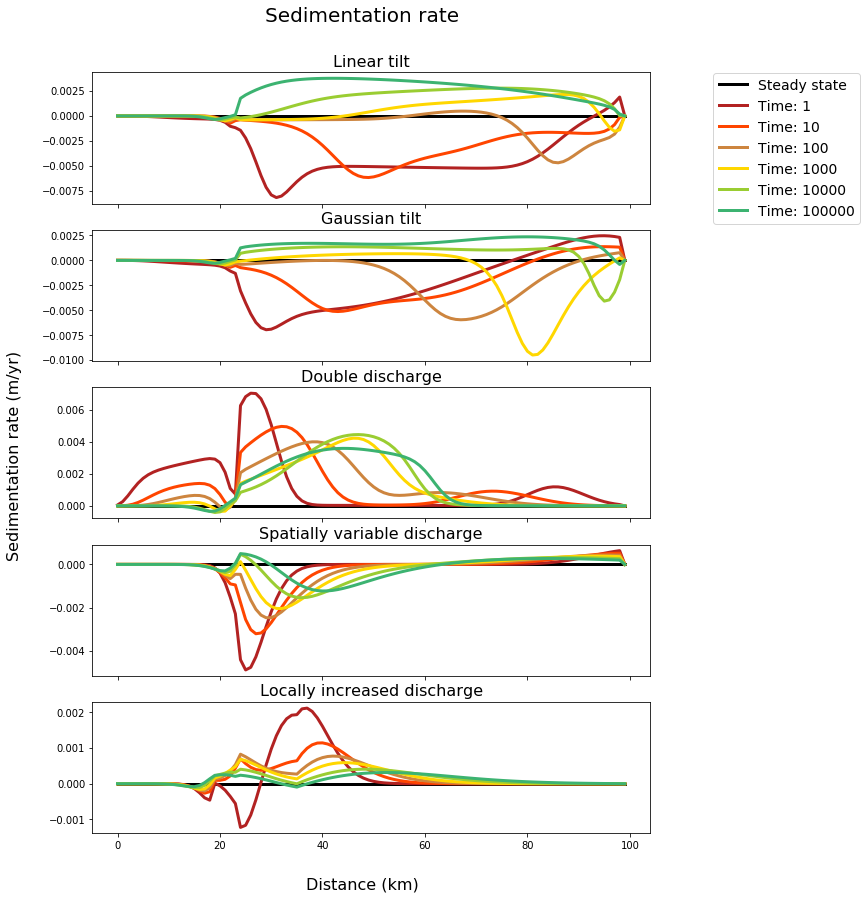

In [33]:
# now make a very similar plot to examine sedimentation rate

fig, axs = plt.subplots(5, sharex = True, figsize = (10, 14))

fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Sedimentation rate', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Sedimentation rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

axs[0].plot(x/1000, sedimentation_rate_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
axs[0].plot(x/1000, sedimentation_rate_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
axs[0].plot(x/1000, sedimentation_rate_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
axs[0].plot(x/1000, sedimentation_rate_exp_1d, label = 'Time: 100', color = 'peru', linewidth = 3)
axs[0].plot(x/1000, sedimentation_rate_exp_1e, label = 'Time: 1000', color = 'gold', linewidth = 3)
axs[0].plot(x/1000, sedimentation_rate_exp_1f, label = 'Time: 10000', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x/1000, sedimentation_rate_exp_1g, label = 'Time: 100000', color = 'mediumseagreen', linewidth = 3)
# axs[0].plot(x/1000, sedimentation_rate_exp_1h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
axs[0].legend(bbox_to_anchor=(1.1, 1.05), fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

axs[1].plot(x/1000, sedimentation_rate_exp_2a, color = 'k', linewidth = 3)
axs[1].plot(x/1000, sedimentation_rate_exp_2b, color = 'firebrick', linewidth = 3)
axs[1].plot(x/1000, sedimentation_rate_exp_2c, color = 'orangered', linewidth = 3)
axs[1].plot(x/1000, sedimentation_rate_exp_2d, color = 'peru', linewidth = 3)
axs[1].plot(x/1000, sedimentation_rate_exp_2e, color = 'gold', linewidth = 3)
axs[1].plot(x/1000, sedimentation_rate_exp_2f, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x/1000, sedimentation_rate_exp_2g, color = 'mediumseagreen', linewidth = 3)
# axs[1].plot(x/1000, sedimentation_rate_exp_2h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[1].legend(fontsize = 14)
axs[1].set_title('Gaussian tilt', fontsize = 16)

axs[2].plot(x/1000, sedimentation_rate_exp_3a, color = 'k', linewidth = 3)
axs[2].plot(x/1000, sedimentation_rate_exp_3b, color = 'firebrick', linewidth = 3)
axs[2].plot(x/1000, sedimentation_rate_exp_3c, color = 'orangered', linewidth = 3)
axs[2].plot(x/1000, sedimentation_rate_exp_3d, color = 'peru', linewidth = 3)
axs[2].plot(x/1000, sedimentation_rate_exp_3e, color = 'gold', linewidth = 3)
axs[2].plot(x/1000, sedimentation_rate_exp_3f, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x/1000, sedimentation_rate_exp_3g, color = 'mediumseagreen', linewidth = 3)
# axs[2].plot(x/1000, sedimentation_rate_exp_3h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[2].legend(fontsize = 14)
axs[2].set_title('Double discharge', fontsize = 16)

axs[3].plot(x/1000, sedimentation_rate_exp_4a, color = 'k', linewidth = 3)
axs[3].plot(x/1000, sedimentation_rate_exp_4b, color = 'firebrick', linewidth = 3)
axs[3].plot(x/1000, sedimentation_rate_exp_4c, color = 'orangered', linewidth = 3)
axs[3].plot(x/1000, sedimentation_rate_exp_4d, color = 'peru', linewidth = 3)
axs[3].plot(x/1000, sedimentation_rate_exp_4e, color = 'gold', linewidth = 3)
axs[3].plot(x/1000, sedimentation_rate_exp_4f, color = 'yellowgreen', linewidth = 3)
axs[3].plot(x/1000, sedimentation_rate_exp_4g, color = 'mediumseagreen', linewidth = 3)
# axs[3].plot(x/1000, sedimentation_rate_exp_4h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[3].set_title('Spatially variable discharge', fontsize = 16)

axs[4].plot(x/1000, sedimentation_rate_exp_5a, color = 'k', linewidth = 3)
axs[4].plot(x/1000, sedimentation_rate_exp_5b, color = 'firebrick', linewidth = 3)
axs[4].plot(x/1000, sedimentation_rate_exp_5c, color = 'orangered', linewidth = 3)
axs[4].plot(x/1000, sedimentation_rate_exp_5d, color = 'peru', linewidth = 3)
axs[4].plot(x/1000, sedimentation_rate_exp_5e, color = 'gold', linewidth = 3)
axs[4].plot(x/1000, sedimentation_rate_exp_5f, color = 'yellowgreen', linewidth = 3)
axs[4].plot(x/1000, sedimentation_rate_exp_5g, color = 'mediumseagreen', linewidth = 3)
# axs[3].plot(x/1000, sedimentation_rate_exp_4h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[4].set_title('Locally increased discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/AGU 2021/sedimentation rates.png')

Text(0.5, 1.0, 'Locally increased discharge')

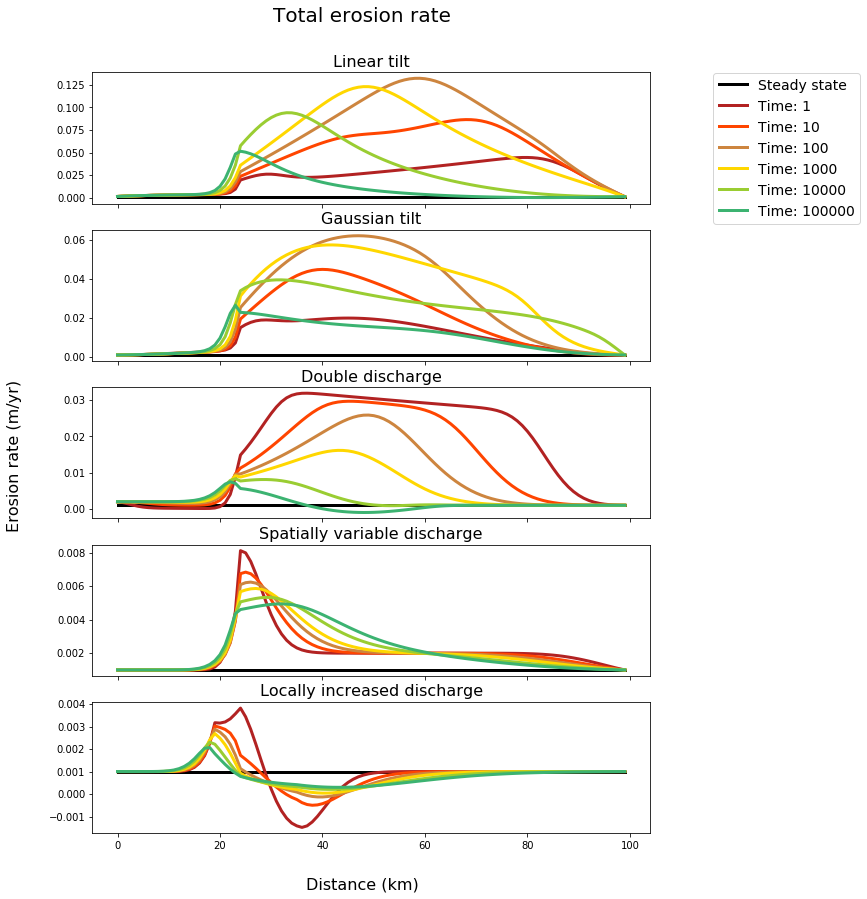

In [34]:
# and finally, a plot to look at total erosion rate

fig, axs = plt.subplots(5, sharex = True, figsize = (10, 14))

fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Total erosion rate', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Erosion rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

axs[0].plot(x/1000, total_erosion_rate_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
axs[0].plot(x/1000, total_erosion_rate_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
axs[0].plot(x/1000, total_erosion_rate_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
axs[0].plot(x/1000, total_erosion_rate_exp_1d, label = 'Time: 100', color = 'peru', linewidth = 3)
axs[0].plot(x/1000, total_erosion_rate_exp_1e, label = 'Time: 1000', color = 'gold', linewidth = 3)
axs[0].plot(x/1000, total_erosion_rate_exp_1f, label = 'Time: 10000', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x/1000, total_erosion_rate_exp_1g, label = 'Time: 100000', color = 'mediumseagreen', linewidth = 3)
# axs[0].plot(x/1000, total_erosion_rate_exp_1h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
axs[0].legend(bbox_to_anchor=(1.1, 1.05), fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

axs[1].plot(x/1000, total_erosion_rate_exp_2a, color = 'k', linewidth = 3)
axs[1].plot(x/1000, total_erosion_rate_exp_2b, color = 'firebrick', linewidth = 3)
axs[1].plot(x/1000, total_erosion_rate_exp_2c, color = 'orangered', linewidth = 3)
axs[1].plot(x/1000, total_erosion_rate_exp_2d, color = 'peru', linewidth = 3)
axs[1].plot(x/1000, total_erosion_rate_exp_2e, color = 'gold', linewidth = 3)
axs[1].plot(x/1000, total_erosion_rate_exp_2f, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x/1000, total_erosion_rate_exp_2g, color = 'mediumseagreen', linewidth = 3)
# axs[1].plot(x/1000, total_erosion _rate_exp_2h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[1].legend(fontsize = 14)
axs[1].set_title('Gaussian tilt', fontsize = 16)

axs[2].plot(x/1000, total_erosion_rate_exp_3a, color = 'k', linewidth = 3)
axs[2].plot(x/1000, total_erosion_rate_exp_3b, color = 'firebrick', linewidth = 3)
axs[2].plot(x/1000, total_erosion_rate_exp_3c, color = 'orangered', linewidth = 3)
axs[2].plot(x/1000, total_erosion_rate_exp_3d, color = 'peru', linewidth = 3)
axs[2].plot(x/1000, total_erosion_rate_exp_3e, color = 'gold', linewidth = 3)
axs[2].plot(x/1000, total_erosion_rate_exp_3f, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x/1000, total_erosion_rate_exp_3g, color = 'mediumseagreen', linewidth = 3)
# axs[2].plot(x/1000, total_erosion_rate_exp_3h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[2].legend(fontsize = 14)
axs[2].set_title('Double discharge', fontsize = 16)

axs[3].plot(x/1000, total_erosion_rate_exp_4a, color = 'k', linewidth = 3)
axs[3].plot(x/1000, total_erosion_rate_exp_4b, color = 'firebrick', linewidth = 3)
axs[3].plot(x/1000, total_erosion_rate_exp_4c, color = 'orangered', linewidth = 3)
axs[3].plot(x/1000, total_erosion_rate_exp_4d, color = 'peru', linewidth = 3)
axs[3].plot(x/1000, total_erosion_rate_exp_4e, color = 'gold', linewidth = 3)
axs[3].plot(x/1000, total_erosion_rate_exp_4f, color = 'yellowgreen', linewidth = 3)
axs[3].plot(x/1000, total_erosion_rate_exp_4g, color = 'mediumseagreen', linewidth = 3)
# axs[3].plot(x/1000, stotal_erosion_rate_exp_4h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[3].set_title('Spatially variable discharge', fontsize = 16)

axs[4].plot(x/1000, total_erosion_rate_exp_5a, color = 'k', linewidth = 3)
axs[4].plot(x/1000, total_erosion_rate_exp_5b, color = 'firebrick', linewidth = 3)
axs[4].plot(x/1000, total_erosion_rate_exp_5c, color = 'orangered', linewidth = 3)
axs[4].plot(x/1000, total_erosion_rate_exp_5d, color = 'peru', linewidth = 3)
axs[4].plot(x/1000, total_erosion_rate_exp_5e, color = 'gold', linewidth = 3)
axs[4].plot(x/1000, total_erosion_rate_exp_5f, color = 'yellowgreen', linewidth = 3)
axs[4].plot(x/1000, total_erosion_rate_exp_5g, color = 'mediumseagreen', linewidth = 3)
# axs[3].plot(x/1000, stotal_erosion_rate_exp_4h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[4].set_title('Locally increased discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/AGU 2021/total erosion rates.png')

In [35]:
# calculate differences to add back in to get profiles on the same outlet elevation
add_in_exp_1b = topography_exp_1b[-1] - topography_exp_1b[-1]
add_in_exp_1c = topography_exp_1b[-1] - topography_exp_1c[-1]
add_in_exp_1d = topography_exp_1b[-1] - topography_exp_1d[-1]
add_in_exp_1e = topography_exp_1b[-1] - topography_exp_1e[-1]
add_in_exp_1f = topography_exp_1b[-1] - topography_exp_1f[-1]
add_in_exp_1g = topography_exp_1b[-1] - topography_exp_1g[-1]
add_in_exp_1h = topography_exp_1b[-1] - topography_exp_1h[-1]

add_in_exp_2b = topography_exp_2b[-1] - topography_exp_2b[-1]
add_in_exp_2c = topography_exp_2b[-1] - topography_exp_2c[-1]
add_in_exp_2d = topography_exp_2b[-1] - topography_exp_2d[-1]
add_in_exp_2e = topography_exp_2b[-1] - topography_exp_2e[-1]
add_in_exp_2f = topography_exp_2b[-1] - topography_exp_2f[-1]
add_in_exp_2g = topography_exp_2b[-1] - topography_exp_2g[-1]
add_in_exp_2h = topography_exp_2b[-1] - topography_exp_2h[-1]

add_in_exp_3b = topography_exp_3b[-1] - topography_exp_3b[-1]
add_in_exp_3c = topography_exp_3b[-1] - topography_exp_3c[-1]
add_in_exp_3d = topography_exp_3b[-1] - topography_exp_3d[-1]
add_in_exp_3e = topography_exp_3b[-1] - topography_exp_3e[-1]
add_in_exp_3f = topography_exp_3b[-1] - topography_exp_3f[-1]
add_in_exp_3g = topography_exp_3b[-1] - topography_exp_3g[-1]
add_in_exp_3h = topography_exp_3b[-1] - topography_exp_3h[-1]

add_in_exp_4b = topography_exp_4b[-1] - topography_exp_4b[-1]
add_in_exp_4c = topography_exp_4b[-1] - topography_exp_4c[-1]
add_in_exp_4d = topography_exp_4b[-1] - topography_exp_4d[-1]
add_in_exp_4e = topography_exp_4b[-1] - topography_exp_4e[-1]
add_in_exp_4f = topography_exp_4b[-1] - topography_exp_4f[-1]
add_in_exp_4g = topography_exp_4b[-1] - topography_exp_4g[-1]
add_in_exp_4h = topography_exp_4b[-1] - topography_exp_4h[-1]

add_in_exp_5b = topography_exp_5b[-1] - topography_exp_5b[-1]
add_in_exp_5c = topography_exp_5b[-1] - topography_exp_5c[-1]
add_in_exp_5d = topography_exp_5b[-1] - topography_exp_5d[-1]
add_in_exp_5e = topography_exp_5b[-1] - topography_exp_5e[-1]
add_in_exp_5f = topography_exp_5b[-1] - topography_exp_5f[-1]
add_in_exp_5g = topography_exp_5b[-1] - topography_exp_5g[-1]
add_in_exp_5h = topography_exp_5b[-1] - topography_exp_5h[-1]

Text(0.5, 1.0, 'Locally increased discharge')

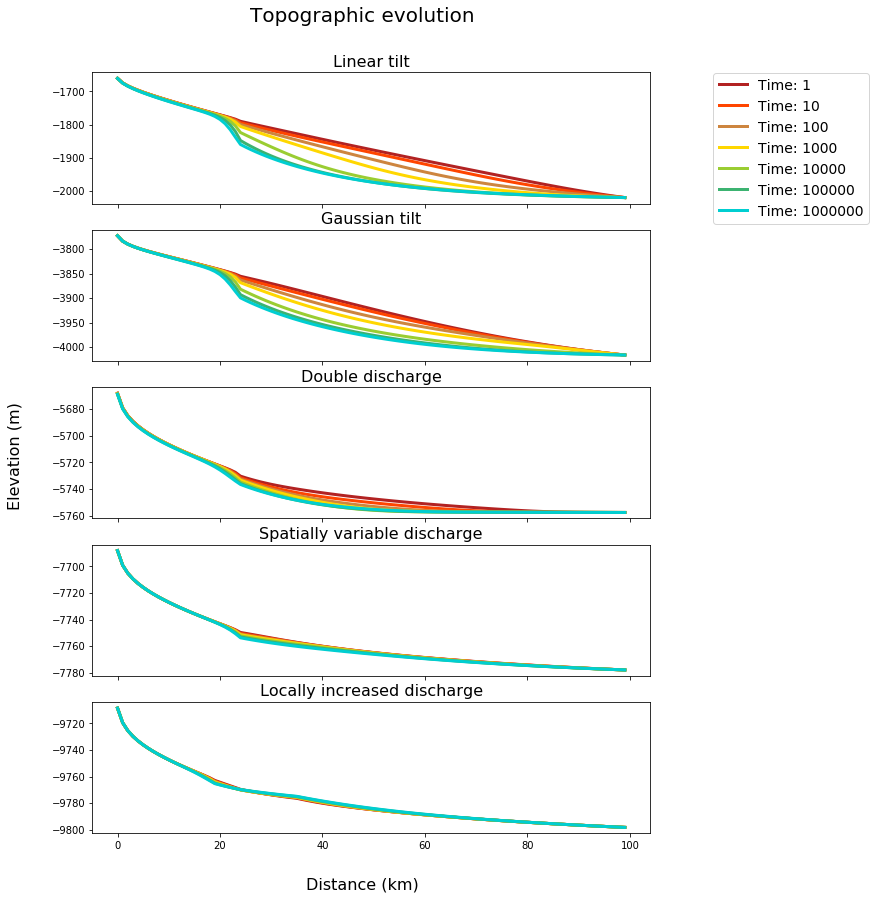

In [36]:
# topographic evolution plot

fig, axs = plt.subplots(5, sharex = True, figsize = (10, 14))

fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Topographic evolution', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Elevation (m)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x/1000, topography_exp_1a + add_in_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1b + add_in_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1c + add_in_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1d + add_in_exp_1d, label = 'Time: 100', color = 'peru', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1e + add_in_exp_1e, label = 'Time: 1000', color = 'gold', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1f + add_in_exp_1f, label = 'Time: 10000', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1g + add_in_exp_1g, label = 'Time: 100000', color = 'mediumseagreen', linewidth = 3)
axs[0].plot(x/1000, topography_exp_1h + add_in_exp_1h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
axs[0].legend(bbox_to_anchor=(1.1, 1.05), fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

# axs[1].plot(x/1000, topography_exp_2a + add_in_exp_2a, color = 'k', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2b + add_in_exp_2b, color = 'firebrick', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2c + add_in_exp_2c, color = 'orangered', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2d + add_in_exp_2d, color = 'peru', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2e + add_in_exp_2e, color = 'gold', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2f + add_in_exp_2f, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2g + add_in_exp_2g, color = 'mediumseagreen', linewidth = 3)
axs[1].plot(x/1000, topography_exp_2h + add_in_exp_2h, color = 'darkturquoise', linewidth = 3)
# axs[1].legend(fontsize = 14)
axs[1].set_title('Gaussian tilt', fontsize = 16)

# axs[2].plot(x/1000, topography_exp_3a + add_in_exp_3a, color = 'k', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3b + add_in_exp_3b, color = 'firebrick', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3c + add_in_exp_3c, color = 'orangered', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3d + add_in_exp_3d, color = 'peru', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3e + add_in_exp_3e, color = 'gold', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3f + add_in_exp_3f, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3g + add_in_exp_3g, color = 'mediumseagreen', linewidth = 3)
axs[2].plot(x/1000, topography_exp_3h + add_in_exp_3h, color = 'darkturquoise', linewidth = 3)
# # axs[2].legend(fontsize = 14)
axs[2].set_title('Double discharge', fontsize = 16)

# axs[3].plot(x/1000, topography_exp_4a + add_in_exp_4a, color = 'k', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4b + add_in_exp_4b, color = 'firebrick', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4c + add_in_exp_4c, color = 'orangered', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4d + add_in_exp_4d, color = 'peru', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4e + add_in_exp_4e, color = 'gold', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4f + add_in_exp_4f, color = 'yellowgreen', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4g + add_in_exp_4g, color = 'mediumseagreen', linewidth = 3)
axs[3].plot(x/1000, topography_exp_4h + add_in_exp_4h, color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[3].set_title('Spatially variable discharge', fontsize = 16)

# axs[3].plot(x/1000, topography_exp_4a + add_in_exp_4a, color = 'k', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5b + add_in_exp_5b, color = 'firebrick', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5c + add_in_exp_5c, color = 'orangered', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5d + add_in_exp_5d, color = 'peru', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5e + add_in_exp_5e, color = 'gold', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5f + add_in_exp_5f, color = 'yellowgreen', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5g + add_in_exp_5g, color = 'mediumseagreen', linewidth = 3)
axs[4].plot(x/1000, topography_exp_5h + add_in_exp_5h, color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[4].set_title('Locally increased discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/AGU 2021/total erosion rates.png')

## NOTES:

Okay... this is a little disappointing. It doesn't appear to be doing what we "expect," i.e., digging a hole at the mountain front. Instead we're seeing increased erosion downstream propagating upstream. Why?

Text(0.5, 1.0, 'Locally increased discharge')

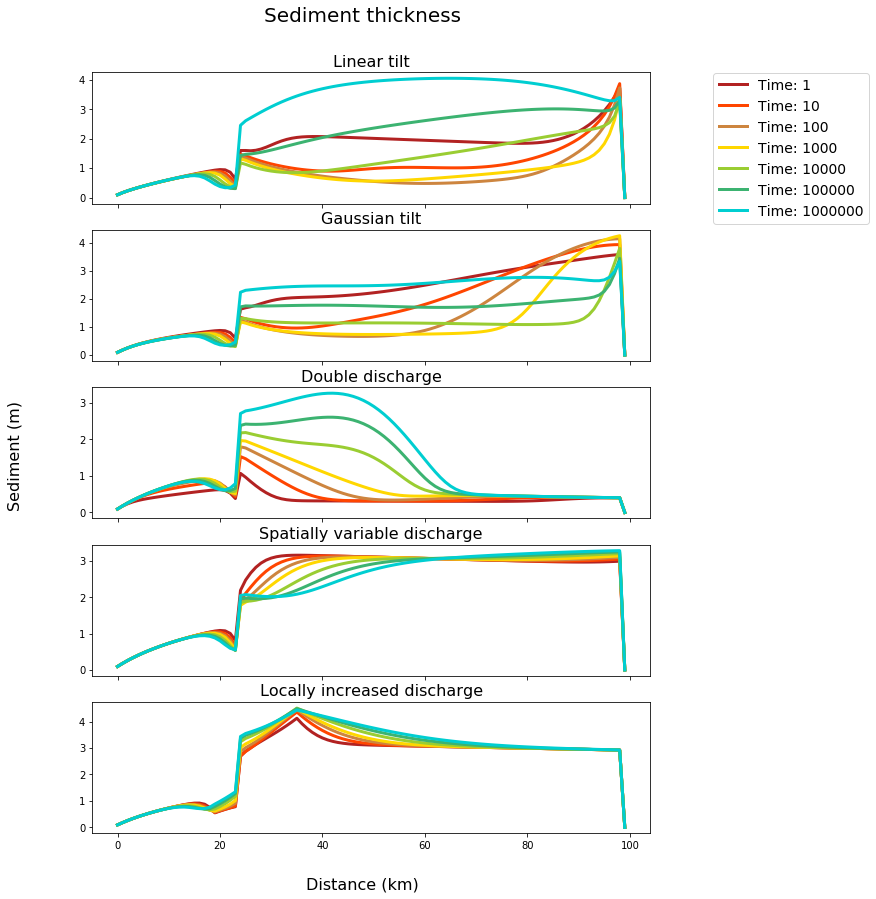

In [37]:
# okay, try looking at sediment thickness

# sediment thickness plot

fig, axs = plt.subplots(5, sharex = True, figsize = (10, 14))

fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Sediment thickness', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Sediment (m)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x/1000, topography_exp_1a + add_in_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1d, label = 'Time: 100', color = 'peru', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1e, label = 'Time: 1000', color = 'gold', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1f, label = 'Time: 10000', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1g, label = 'Time: 100000', color = 'mediumseagreen', linewidth = 3)
axs[0].plot(x/1000, sediment_thickness_exp_1h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
axs[0].legend(bbox_to_anchor=(1.1, 1.05), fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

# axs[1].plot(x/1000, topography_exp_2a + add_in_exp_2a, color = 'k', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2b, color = 'firebrick', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2c, color = 'orangered', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2d, color = 'peru', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2e, color = 'gold', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2f, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2g, color = 'mediumseagreen', linewidth = 3)
axs[1].plot(x/1000, sediment_thickness_exp_2h, color = 'darkturquoise', linewidth = 3)
# axs[1].legend(fontsize = 14)
axs[1].set_title('Gaussian tilt', fontsize = 16)

# axs[2].plot(x/1000, topography_exp_3a + add_in_exp_3a, color = 'k', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3b, color = 'firebrick', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3c, color = 'orangered', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3d, color = 'peru', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3e, color = 'gold', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3f, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3g, color = 'mediumseagreen', linewidth = 3)
axs[2].plot(x/1000, sediment_thickness_exp_3h, color = 'darkturquoise', linewidth = 3)
# # axs[2].legend(fontsize = 14)
axs[2].set_title('Double discharge', fontsize = 16)

# axs[3].plot(x/1000, topography_exp_4a + add_in_exp_4a, color = 'k', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4b, color = 'firebrick', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4c, color = 'orangered', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4d, color = 'peru', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4e, color = 'gold', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4f, color = 'yellowgreen', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4g, color = 'mediumseagreen', linewidth = 3)
axs[3].plot(x/1000, sediment_thickness_exp_4h, color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[3].set_title('Spatially variable discharge', fontsize = 16)

# axs[3].plot(x/1000, topography_exp_4a + add_in_exp_4a, color = 'k', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5b, color = 'firebrick', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5c, color = 'orangered', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5d, color = 'peru', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5e, color = 'gold', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5f, color = 'yellowgreen', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5g, color = 'mediumseagreen', linewidth = 3)
axs[4].plot(x/1000, sediment_thickness_exp_5h, color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[4].set_title('Locally increased discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/AGU 2021/total erosion rates.png')

Text(0.5, 1.0, 'Locally increased discharge')

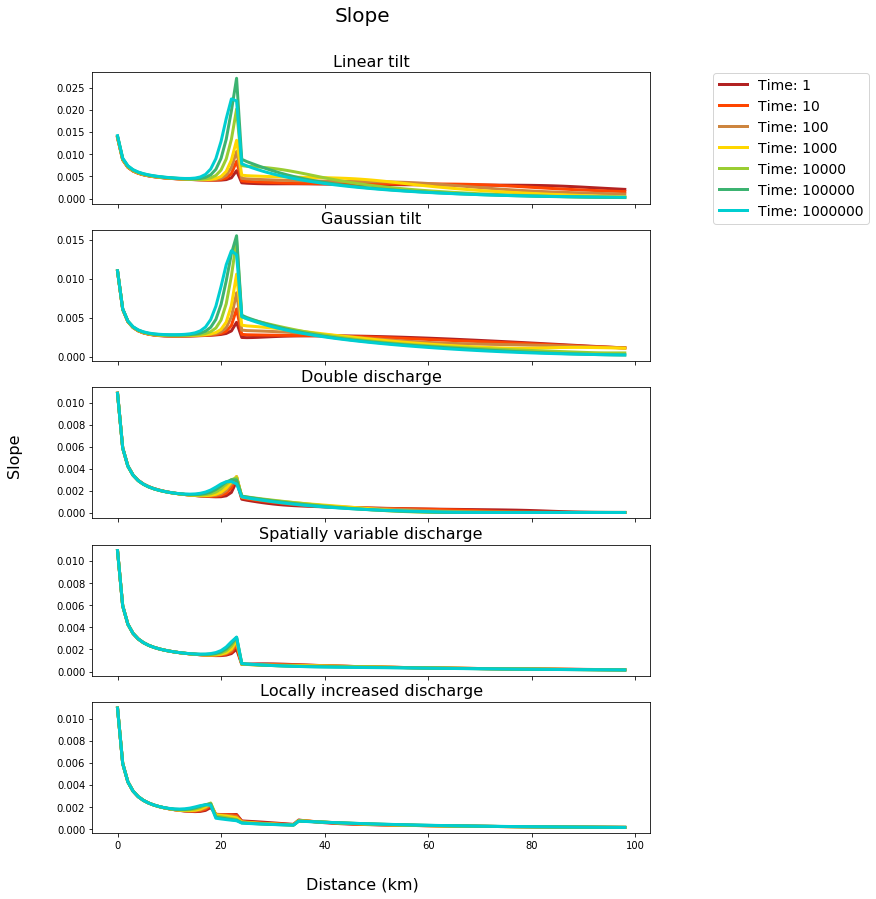

In [38]:
# okay, try looking at sediment thickness

# sediment thickness plot

fig, axs = plt.subplots(5, sharex = True, figsize = (10, 14))

fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Slope', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Slope', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x/1000, topography_exp_1a + add_in_exp_1a, label = 'Steady state', color = 'k', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1b, label = 'Time: 1', color = 'firebrick', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1c, label = 'Time: 10', color = 'orangered', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1d, label = 'Time: 100', color = 'peru', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1e, label = 'Time: 1000', color = 'gold', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1f, label = 'Time: 10000', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1g, label = 'Time: 100000', color = 'mediumseagreen', linewidth = 3)
axs[0].plot(x[:-1]/1000, slope_exp_1h, label = 'Time: 1000000', color = 'darkturquoise', linewidth = 3)
axs[0].legend(bbox_to_anchor=(1.1, 1.05), fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

# axs[1].plot(x/1000, topography_exp_2a + add_in_exp_2a, color = 'k', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2b, color = 'firebrick', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2c, color = 'orangered', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2d, color = 'peru', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2e, color = 'gold', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2f, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2g, color = 'mediumseagreen', linewidth = 3)
axs[1].plot(x[:-1]/1000, slope_exp_2h, color = 'darkturquoise', linewidth = 3)
# axs[1].legend(fontsize = 14)
axs[1].set_title('Gaussian tilt', fontsize = 16)

# axs[2].plot(x/1000, topography_exp_3a + add_in_exp_3a, color = 'k', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3b, color = 'firebrick', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3c, color = 'orangered', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3d, color = 'peru', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3e, color = 'gold', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3f, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3g, color = 'mediumseagreen', linewidth = 3)
axs[2].plot(x[:-1]/1000, slope_exp_3h, color = 'darkturquoise', linewidth = 3)
# # axs[2].legend(fontsize = 14)
axs[2].set_title('Double discharge', fontsize = 16)

# axs[3].plot(x/1000, topography_exp_4a + add_in_exp_4a, color = 'k', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4b, color = 'firebrick', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4c, color = 'orangered', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4d, color = 'peru', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4e, color = 'gold', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4f, color = 'yellowgreen', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4g, color = 'mediumseagreen', linewidth = 3)
axs[3].plot(x[:-1]/1000, slope_exp_4h, color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[3].set_title('Spatially variable discharge', fontsize = 16)

# axs[3].plot(x/1000, topography_exp_4a + add_in_exp_4a, color = 'k', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5b, color = 'firebrick', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5c, color = 'orangered', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5d, color = 'peru', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5e, color = 'gold', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5f, color = 'yellowgreen', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5g, color = 'mediumseagreen', linewidth = 3)
axs[4].plot(x[:-1]/1000, slope_exp_5h, color = 'darkturquoise', linewidth = 3)
# axs[3].legend(fontsize = 14)
axs[4].set_title('Locally increased discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/AGU 2021/total erosion rates.png')

In [39]:
x

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
       54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
       63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000,
       72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000,
       81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000,
       90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000,
       99000])

In [40]:
from matplotlib.animation import FuncAnimation

In [49]:
from celluloid import Camera

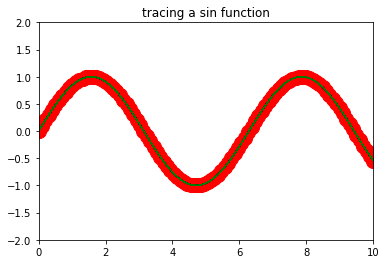

In [51]:
#Creating Data
x = np.linspace(0, 10, 100)
 
#defining a function to return sine of input values.
def fun(i):
    y = np.sin(i)
    return y
 
x_y = fun(x)
 
#Creating matplotlib figure and camera object
fig = plt.figure()
plt.xlim(0,10)
plt.ylim(-2,2)
camera = Camera(fig)
 
#Looping the data and capturing frame at each iteration
for i in x:
    plt.plot(x,x_y , color = 'green' , lw = 0.8)
    f = plt.scatter(i, fun(i) , color = 'red' , s = 200)
    plt.title('tracing a sin function')
    camera.snap()

In [52]:
#Creating the animation from captured frames
animation = camera.animate(interval = 200, repeat = True, repeat_delay = 500)

In [53]:
animation